In [1]:
import numpy as np
import json
import tensorflow as tf
import torch
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
from itertools import combinations 
import matplotlib.transforms
import collections
import re
import random

# Attention analysis

## Extracting attention from different models

### Loading the models

In [2]:
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, GPT2LMHeadModel, GPT2Tokenizer, AutoModelForMaskedLM

In [3]:
model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
model_name = "DeepPavlov/bert-base-cased-conversational"
bert_conversational_tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_conversational_model = AutoModel.from_pretrained(model_name, output_attentions=True)

Some weights of the model checkpoint at DeepPavlov/bert-base-cased-conversational were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
model_name = "Elron/bleurt-base-128"
bleurt_model = AutoModelForSequenceClassification.from_pretrained(model_name, output_attentions=True)
bleurt_tokenizer = AutoTokenizer.from_pretrained(model_name)

In [6]:
model_name = "TODBERT/TOD-BERT-JNT-V1"
todbert_tokenizer = AutoTokenizer.from_pretrained(model_name)
todbert_model = AutoModelForMaskedLM.from_pretrained(model_name, output_attentions=True)

### Preparing inputs for the models

In [7]:
#dialoghi interi
lst_dict = []
with open('./data/EMNLP_dataset/dialogues_text.txt', 'r') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        bleurt_tokenized = bleurt_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        bert_conversational_tokenized = bert_conversational_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        if len(bleurt_tokenized) < 513 and len(bert_conversational_tokenized) < 513:
            lst_dict.append({'bert': "[CLS] " + l.replace("__eou__", "[SEP]").replace("\n", "").replace("'", " ' "), 
                             'txt': l.replace("\n", "").replace("'", " ' ")})

100%|██████████| 13118/13118 [00:09<00:00, 1436.45it/s]


#### Non coherent dialogues

In [8]:
#dialoghi interi
utts = []
lengths = []
with open('./data/EMNLP_dataset/dialogues_text.txt', 'r') as f:
    lines = f.readlines()
    tot_dialogues = len(lines)
    for l in tqdm(lines):
        curr_lst = [utt for utt in l.split("__eou__") if (utt.strip() != "")]
        utts += curr_lst
        lengths.append(len(curr_lst))

100%|██████████| 13118/13118 [00:00<00:00, 249149.27it/s]


In [9]:
dialogues = ""
len_list = random.sample(lengths, len(lengths))
utts_list = random.sample(utts, len(utts))

In [10]:
for i in tqdm(np.arange(len(lengths))):
    dialogue_length = len_list[i]-3 if len_list[i]>4 else len_list[i]
    dialogue = ""
    for _ in np.arange(dialogue_length):
        dialogue += utts_list[i] + "__eou__"
    dialogues += dialogue +"\n"

100%|██████████| 13118/13118 [00:00<00:00, 217603.71it/s]


In [11]:
with open('./data/EMNLP_dataset/dialogues_text_not_coherent.txt', 'w') as f:
    f.write(dialogues)

In [12]:
#dialoghi interi
lst_dict_not_coherent = []
with open('./data/EMNLP_dataset/dialogues_text_not_coherent.txt', 'r') as f:
    lines = f.readlines()
    for l in tqdm(lines):
        bleurt_tokenized = bleurt_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        bert_conversational_tokenized = bert_conversational_tokenizer.encode(l.replace("__eou__", "[SEP]"))[:-1]
        if len(bleurt_tokenized) < 513 and len(bert_conversational_tokenized) < 513:
            lst_dict_not_coherent.append({'bert': "[CLS] " + l.replace("__eou__", "[SEP]").replace("\n", "").replace("'", " ' "),
                             'txt': l.replace("\n", "").replace("'", " ' ")})

100%|██████████| 13118/13118 [00:06<00:00, 1933.71it/s]


### Extracting attentions

In [13]:
def from_torch_tensor2_numpy(tensor):
    arr = np.empty((len(tensor), tensor[0].size()[1], tensor[0].size()[-1], tensor[0].size()[-1]))
    for i, item in enumerate(tensor):
        arr[i] = item[0].cpu().detach().numpy()
    return arr

In [14]:
import spacy
from spacy.symbols import ORTH
nlp = spacy.load("en_core_web_sm")
special_case = [{ORTH: "gonna"}]
nlp.tokenizer.add_special_case("gonna", special_case)
special_case = [{ORTH: "gotta"}]
nlp.tokenizer.add_special_case("gotta", special_case)
special_case = [{ORTH: "cannot"}]
nlp.tokenizer.add_special_case("cannot", special_case)


In [15]:
def from_tkn_to_spacy(dict_txt, tokenizer, model_type):
    txt = dict_txt['txt']
    tkn_spacy, tkn_spacy_aligned = [], ["[CLS]"] if  model_type == 'bert' else []
    head_spacy, head_spacy_aligned = [], [None] if  model_type == 'bert' else []
    word_spacy, word_spacy_aligned =  [], ["[CLS]"] if  model_type == 'bert' else []
    pos_spacy, pos_spacy_aligned =  [], ["[CLS]"] if  model_type == 'bert' else []
    for utt in txt.split("__eou__"):
        doc = nlp(utt)
        for tkn in doc:
            if tkn.text.strip() !="":
                tokenized = tokenizer.convert_ids_to_tokens(tokenizer.encode(tkn.text, return_tensors = 'pt', add_special_tokens = False)[0])
                if len(tokenized) > 1:
                    for _ in tokenized:
                        tkn_spacy_aligned.append(tkn.dep_)
                        head_spacy_aligned.append(tkn.head.i)
                        word_spacy_aligned.append(tkn.text)
                        pos_spacy_aligned.append(tkn.pos_)
                else:
                    tkn_spacy_aligned.append(tkn.dep_)
                    head_spacy_aligned.append(tkn.head.i)
                    word_spacy_aligned.append(tkn.text)
                    pos_spacy_aligned.append(tkn.pos_)
                    tkn_spacy.append(tkn.dep_)
                    head_spacy.append(tkn.head.i)
                    word_spacy.append(tkn.text)
                    pos_spacy.append(tkn.pos_)
        
        tkn_spacy_aligned.append("[SEP]") if model_type == 'bert' else tkn_spacy_aligned.append(dialogpt_tokenizer.eos_token)
        word_spacy_aligned.append("[SEP]") if model_type == 'bert' else word_spacy_aligned.append(dialogpt_tokenizer.eos_token)
        head_spacy_aligned.append("[SEP]") if model_type == 'bert' else head_spacy_aligned.append(dialogpt_tokenizer.eos_token)
        pos_spacy_aligned.append("[SEP]") if model_type == 'bert' else pos_spacy_aligned.append(dialogpt_tokenizer.eos_token)
    
    tkn_spacy = tkn_spacy[:-1] if model_type == 'bert' else tkn_spacy
    tkn_spacy_aligned = tkn_spacy_aligned[:-1] if model_type == 'bert' else tkn_spacy_aligned
    word_spacy_aligned = word_spacy_aligned[:-1] if model_type == 'bert' else word_spacy_aligned
    head_spacy_aligned = head_spacy_aligned[:-1] if model_type == 'bert' else head_spacy_aligned
    pos_spacy_aligned = pos_spacy_aligned[:-1] if model_type == 'bert' else pos_spacy_aligned
    return tkn_spacy, word_spacy, head_spacy, pos_spacy, tkn_spacy_aligned, word_spacy_aligned, head_spacy_aligned, pos_spacy_aligned

In [16]:
models = ['bert', 'tod_bert', 'bleurt', 'bert_conversational']

In [17]:
keys = [('bert', bert_tokenizer, 'bert', bert_model),         
        #('dialogpt', dialogpt_tokenizer, 'gpt2', dialogpt_model), 
        ('tod_bert', todbert_tokenizer, 'bert', todbert_model),
        ('bleurt', bleurt_tokenizer, 'bert', bleurt_model),
        ('bert_conversational', bert_conversational_tokenizer, 'bert', bert_conversational_model)]
        #('gpt2', gpt2_tokenizer, 'gpt2', gpt2_model)]
        

attention_dicts = {
    k: [] for k in models
}

attention_dicts_not_coherent = {
    k: [] for k in models
}

In [20]:
for k, tokenizer, model_type, model in keys:
    for item in tqdm(lst_dict[:300]):
        inputs = tokenizer.encode(item[model_type], 
                                return_tensors = 'pt', 
                                add_special_tokens = False)
        outputs = model(inputs)
        deps, w, h, pos, deps_a, w_a, h_a, pos_a = from_tkn_to_spacy(item, tokenizer, model_type)
        attention_dicts[k].append({'attns' : from_torch_tensor2_numpy(outputs[-1]),
                                'tokens' : tokenizer.convert_ids_to_tokens(inputs[0]),
                                'relns': deps,
                                'words': w,
                                'heads': h,
                                'pos' : pos,
                                'relns_aligned':deps_a,
                                'words_aligned': w_a,
                                'heads_aligned': h_a,
                                'pos_aligned' : pos_a})


100%|██████████| 300/300 [00:25<00:00, 11.88it/s]


In [18]:
for k, tokenizer, model_type, model in keys:
    for item in tqdm(lst_dict_not_coherent[:300]):
        inputs = tokenizer.encode(item[model_type], 
                                return_tensors = 'pt', 
                                add_special_tokens = False)
        outputs = model(inputs)
        deps, w, h, pos, deps_a, w_a, h_a, pos_a = from_tkn_to_spacy(item, tokenizer, model_type)
        attention_dicts_not_coherent[k].append({'attns' : from_torch_tensor2_numpy(outputs[-1]),
                                'tokens' : tokenizer.convert_ids_to_tokens(inputs[0]),
                                'relns': deps,
                                'words': w,
                                'heads': h,
                                'pos' : pos,
                                'relns_aligned':deps_a,
                                'words_aligned': w_a,
                                'heads_aligned': h_a,
                                'pos_aligned' : pos_a})


100%|██████████| 300/300 [00:35<00:00,  8.57it/s]


In [ ]:
#dialoghi interi
for k in attention_dicts:
    output = open(f'./data/data_attention_annotated{k}.pkl', 'wb')
    pickle.dump(attention_dicts[k], output)
    output.close()

In [34]:
#dialoghi non coerenti interi
for k in tqdm(attention_dicts_not_coherent):
    output = open(f'./data/data_attention_annotated_not_coherent{k}.pkl', 'wb')
    pickle.dump(attention_dicts_not_coherent[k], output)
    output.close()

100%|██████████| 4/4 [01:46<00:00, 26.75s/it]


## Attention analysis

#### Data preparation

In [25]:
def data_iterator(data):
  for i, doc in enumerate(data):
    if i % 100 == 0 or i == len(data) - 1:
      print("{:.1f}% done".format(100.0 * (i + 1) / len(data)))
    yield doc["tokens"], np.array(doc["attns"]), doc["words"], doc["relns"], doc["heads"], doc["pos"], doc["relns_aligned"], doc["words_aligned"], doc["heads_aligned"], doc["pos_aligned"]
    
def load_pickle(fname):
    with open(fname, "rb") as f:
        return pickle.load(f)

In [20]:
for k in attention_dicts:
    attention_dicts[k] = load_pickle(f'./data/data_attention_annotated{k}.pkl')

In [21]:
sum([1 for item in attention_dicts['bert'] for i in item['tokens'] if i == "[SEP]"])/len(attention_dicts['bert'])

5.033333333333333

In [16]:
for k in attention_dicts_not_coherent:
    attention_dicts_not_coherent[k] = load_pickle(f'./data/data_attention_annotated_not_coherent{k}.pkl')

In [22]:
sum([1 for item in attention_dicts_not_coherent['bert'] for i in item['tokens'] if i == "[SEP]"])/len(attention_dicts_not_coherent['bert'])

6.33

#### Computing attention to different utterances

In [26]:
def compute_avg_utterance_attn(attn_dict):  
  distribution_attentions_dicts = {
    k: [] for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  avg_attentions_dicts = {
    k: 0 for k in attn_dict.keys() if attn_dict[k] != []
  }
  
  for k in distribution_attentions_dicts:
      data = attn_dict[k]
      n_docs = len(attn_dict[k])
      
      print("Computing token stats")
      for tokens, attns, _, _, _, _, relns_aligned, words_aligned, _, pos_aligned  in data_iterator(data):
        n_tokens = int(tf.shape(attns)[-1])
        sep_positions = [i for i, item in enumerate(tokens) if item in ['[CLS]', '[SEP]']]
        utt_masks = []
        for i in np.arange(len(sep_positions)-1):
            other_utterances = np.array([0 if (j > sep_positions[i] and j < sep_positions[i+1]) or (tokens[j] in ['[CLS]', '[SEP]']) else 1 for j in np.arange(n_tokens)])
            mask = np.zeros(shape = (n_tokens, n_tokens))
            for v in np.arange(n_tokens):
              for w in np.arange(n_tokens):
                #xor: !=
                #or: or
                mask[v][w] = 1 if (v >= sep_positions[i] and v <= sep_positions[i+1]) or (w >= sep_positions[i] and w <= sep_positions[i+1]) else 0
            utt_masks.append(mask)
            
        #check if alignment is correct
        if n_tokens != len(relns_aligned):
          print(relns_aligned[-1])
          for i in np.arange(len(relns_aligned)):
            print(tokens[i], words_aligned[i], relns_aligned[i])

        #get the average attention for each token not belonging to the current utterance
        total_attn = np.zeros(shape = (12, 12))
        for utt in utt_masks:
          denom = int((n_tokens ** 2) - utt.sum(-1).sum(-1))
          #media delle attenzioni esterne
          total_attn += ((attns * utt[np.newaxis, np.newaxis]).sum(-1).sum(-1)) / (denom*len(utt_masks))
        
        distribution_attentions_dicts[k].append(total_attn)
        avg_attentions_dicts[k] += total_attn/n_docs
      break
  return avg_attentions_dicts, distribution_attentions_dicts

In [27]:
avg_attention_dicts, distrib_attention_dicts = compute_avg_utterance_attn(attention_dicts)

Computing token stats
0.3% done
Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-06-07 16:50:01.730831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-07 16:50:01.732388: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


33.7% done
67.0% done
100.0% done


In [28]:
avg_attention_not_coherent_dicts, distrib_attention_not_coherent_dicts = compute_avg_utterance_attn(attention_dicts_not_coherent)

Computing token stats
0.3% done
33.7% done
67.0% done
100.0% done


TypeError: Invalid shape () for image data

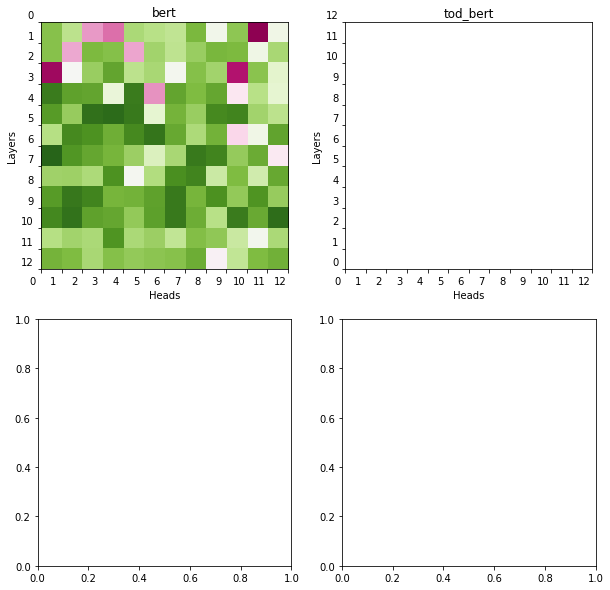

In [29]:
n_row = 2
n_col = int(len(avg_attention_dicts.keys()) / 2)
fig, ax = plt.subplots(n_row, n_col, figsize=(10,10))
plt.set_cmap('PiYG')
I, J = np.unravel_index(np.arange(len(avg_attention_dicts.keys())), shape = (n_row, n_col))
for k, t in enumerate(avg_attention_dicts.keys()):
    i, j = I[k], J[k]
    ax[i][j].set_title(f"{t}")
    ax[i][j].set_xlabel("Heads")
    ax[i][j].set_ylabel("Layers")
    ax[i][j].set_xticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
    ax[i][j].set_yticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
    dx = -8/72.; dy = 0/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax[i][j].xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    dx = 0/72.; dy = 8/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax[i][j].yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    ax[i][j].imshow(avg_attention_dicts[t])

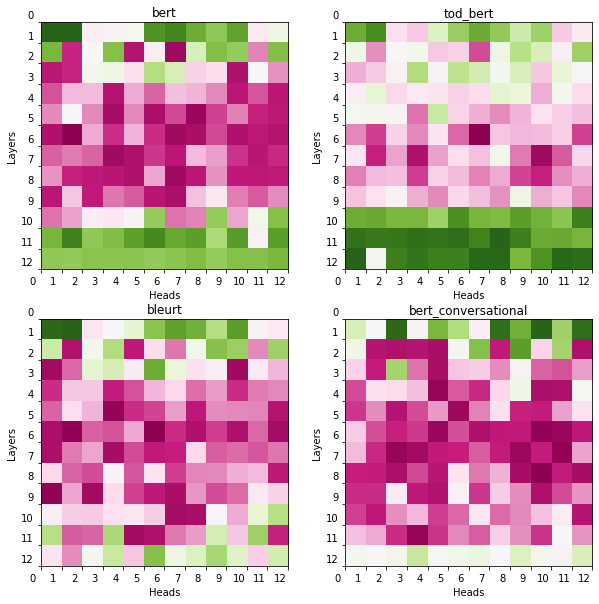

In [25]:
n_row = 2
n_col = int(len(avg_attention_not_coherent_dicts.keys()) / 2)
fig, ax = plt.subplots(n_row, n_col, figsize=(10,10))
plt.set_cmap('PiYG')
I, J = np.unravel_index(np.arange(len(avg_attention_not_coherent_dicts.keys())), shape = (n_row, n_col))
for k, t in enumerate(avg_attention_not_coherent_dicts.keys()):
    i, j = I[k], J[k]
    ax[i][j].set_title(f"{t}")
    ax[i][j].set_xlabel("Heads")
    ax[i][j].set_ylabel("Layers")
    ax[i][j].set_xticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
    ax[i][j].set_yticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
    dx = -8/72.; dy = 0/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax[i][j].xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    dx = 0/72.; dy = 8/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax[i][j].yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    ax[i][j].imshow(avg_attention_not_coherent_dicts[t])

In [31]:
from scipy.stats import ks_2samp

IndexError: list index out of range

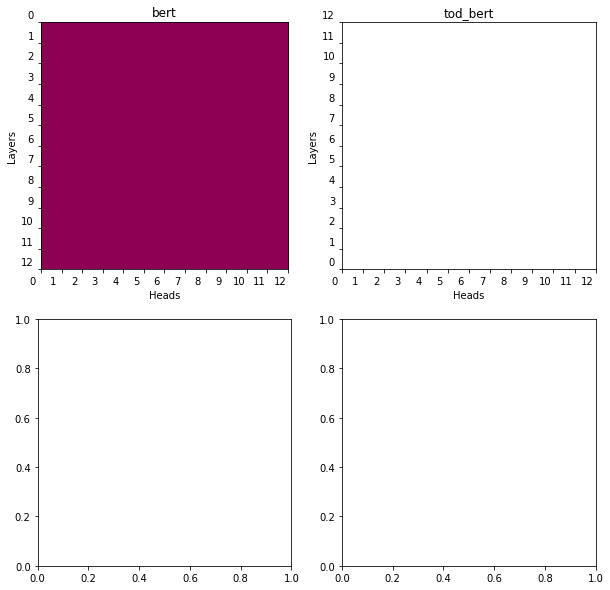

In [32]:
n_row = 2
n_col = int(len(avg_attention_dicts.keys()) / 2)
fig, ax = plt.subplots(n_row, n_col, figsize=(10,10))
plt.set_cmap('PiYG')
I, J = np.unravel_index(np.arange(len(avg_attention_dicts.keys())), shape = (n_row, n_col))
for k, t in enumerate(avg_attention_dicts.keys()):
    i, j = I[k], J[k]
    ax[i][j].set_title(f"{t}")
    ax[i][j].set_xlabel("Heads")
    ax[i][j].set_ylabel("Layers")
    ax[i][j].set_xticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
    ax[i][j].set_yticks(np.arange(-0.5,12.5, 1), labels = np.arange(0,13))
    dx = -8/72.; dy = 0/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax[i][j].xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)

    dx = 0/72.; dy = 8/72. 
    offset = matplotlib.transforms.ScaledTranslation(dx, dy, fig.dpi_scale_trans)
    for label in ax[i][j].yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
    mat = np.zeros((12,12))
    for l in np.arange(12):
        for h in np.arange(12):
            p = ks_2samp(distrib_attention_dicts[t][l][h], distrib_attention_not_coherent_dicts[t][l][h]).pvalue
            mat[l][h] = -1 if p < 0.01 else 1
    ax[i][j].imshow(mat)

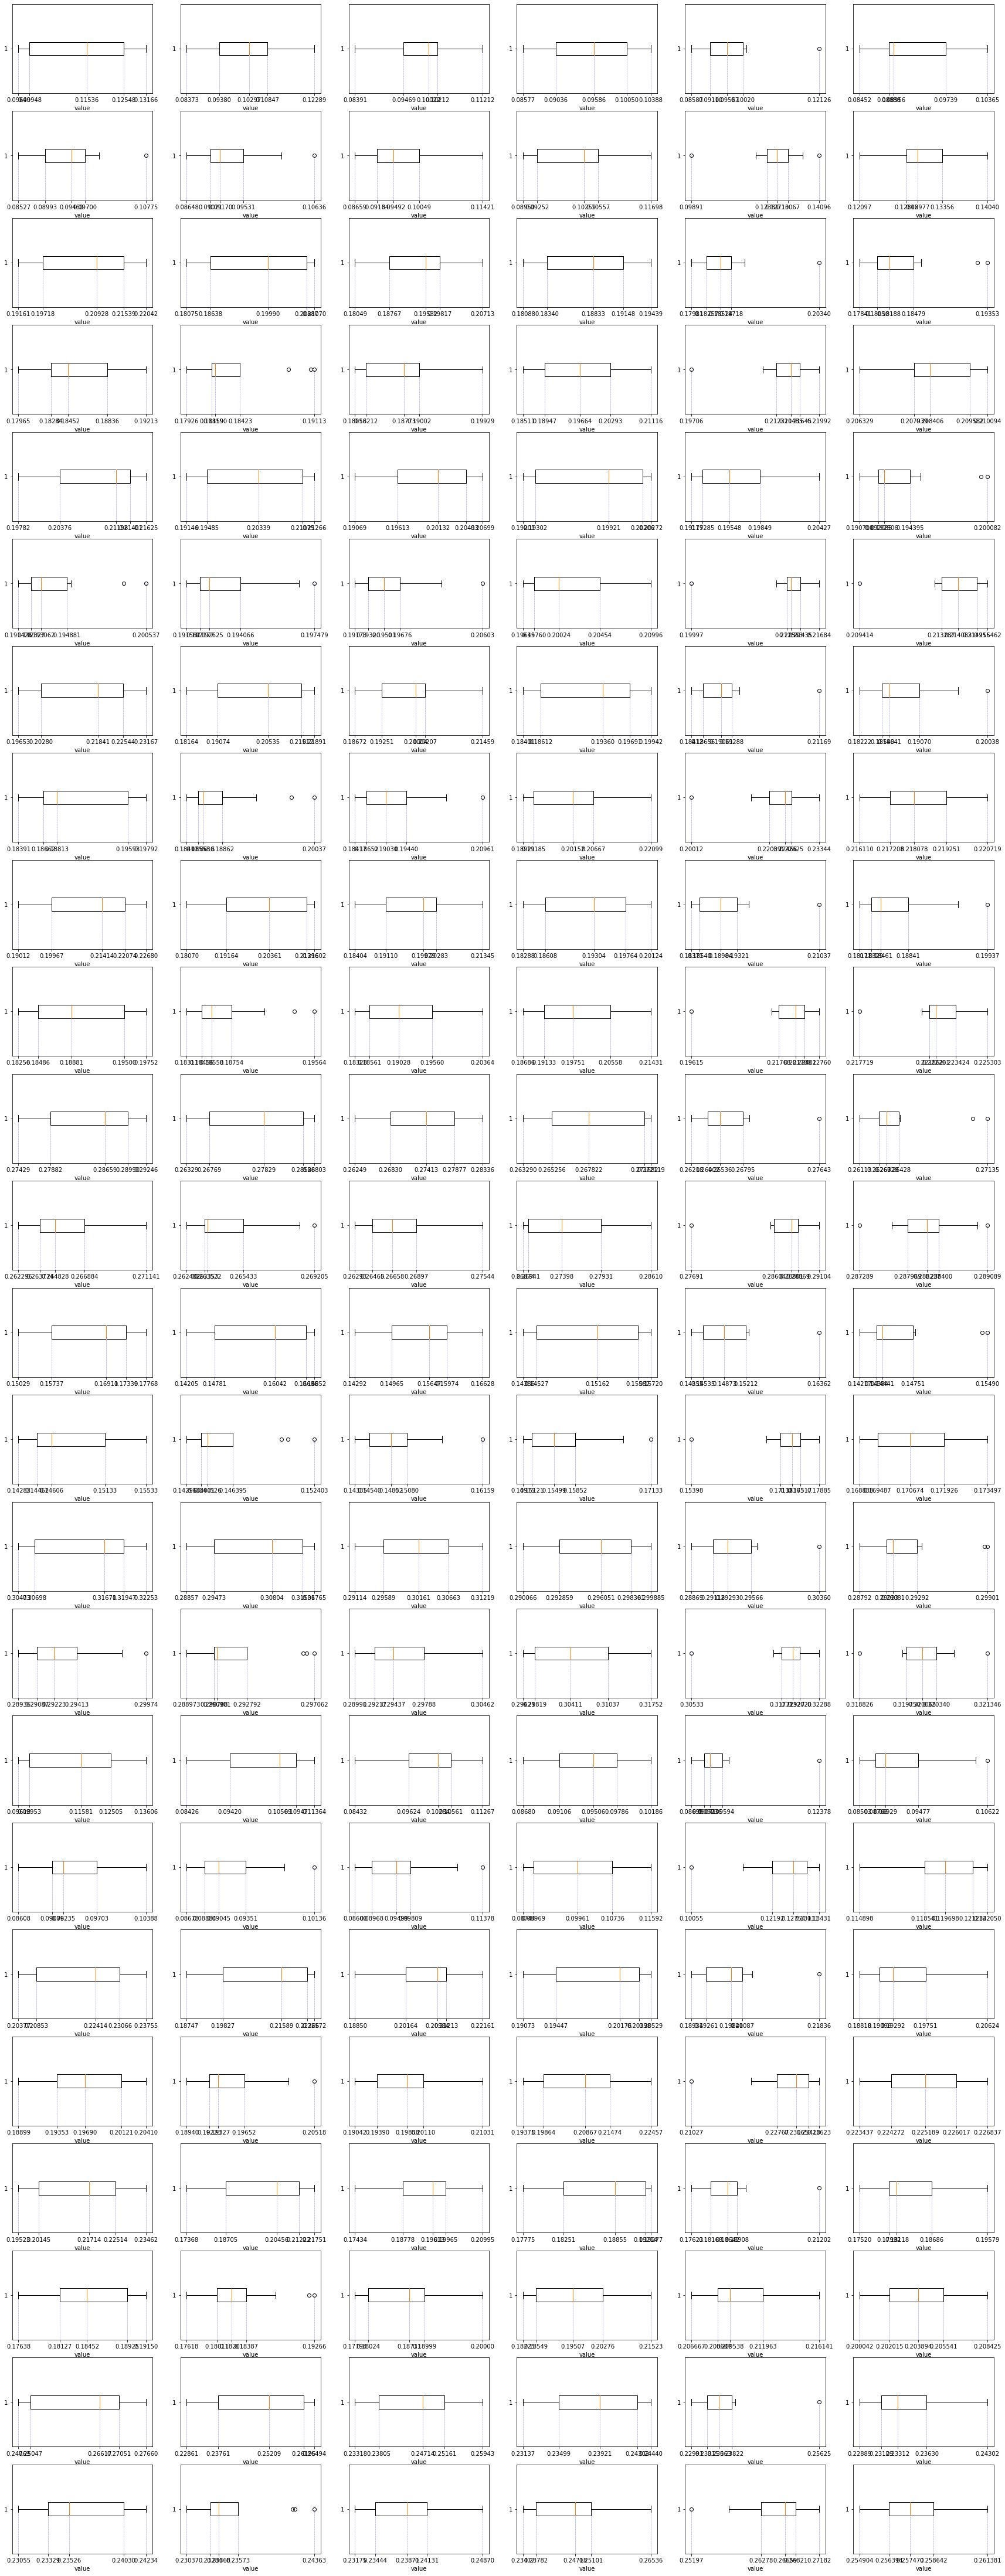

In [31]:
fig, ax = plt.subplots(int(144/6), 6, figsize=(30,80))
I, J = np.unravel_index(np.arange(12*12), shape = (int(144/6), 6))

elem = 0
for l in np.arange(12):
    for h in np.arange(12):
        i, j = I[elem], J[elem]

        ax[i][j].boxplot(distrib_attention_dicts['bert'][l][h], vert=False, manage_ticks=True)
        ax[i][j].set_xlabel('value')

        quantiles = np.quantile(distrib_attention_dicts['bert'][l][h], np.array([0.00, 0.25, 0.50, 0.75, 1.00]))
        ax[i][j].vlines(quantiles, [0] * quantiles.size, [1] * quantiles.size,
                color='b', ls=':', lw=0.5, zorder=0)
        ax[i][j].set_ylim(0.5, 1.5)
        ax[i][j].set_xticks(quantiles)
        elem += 1

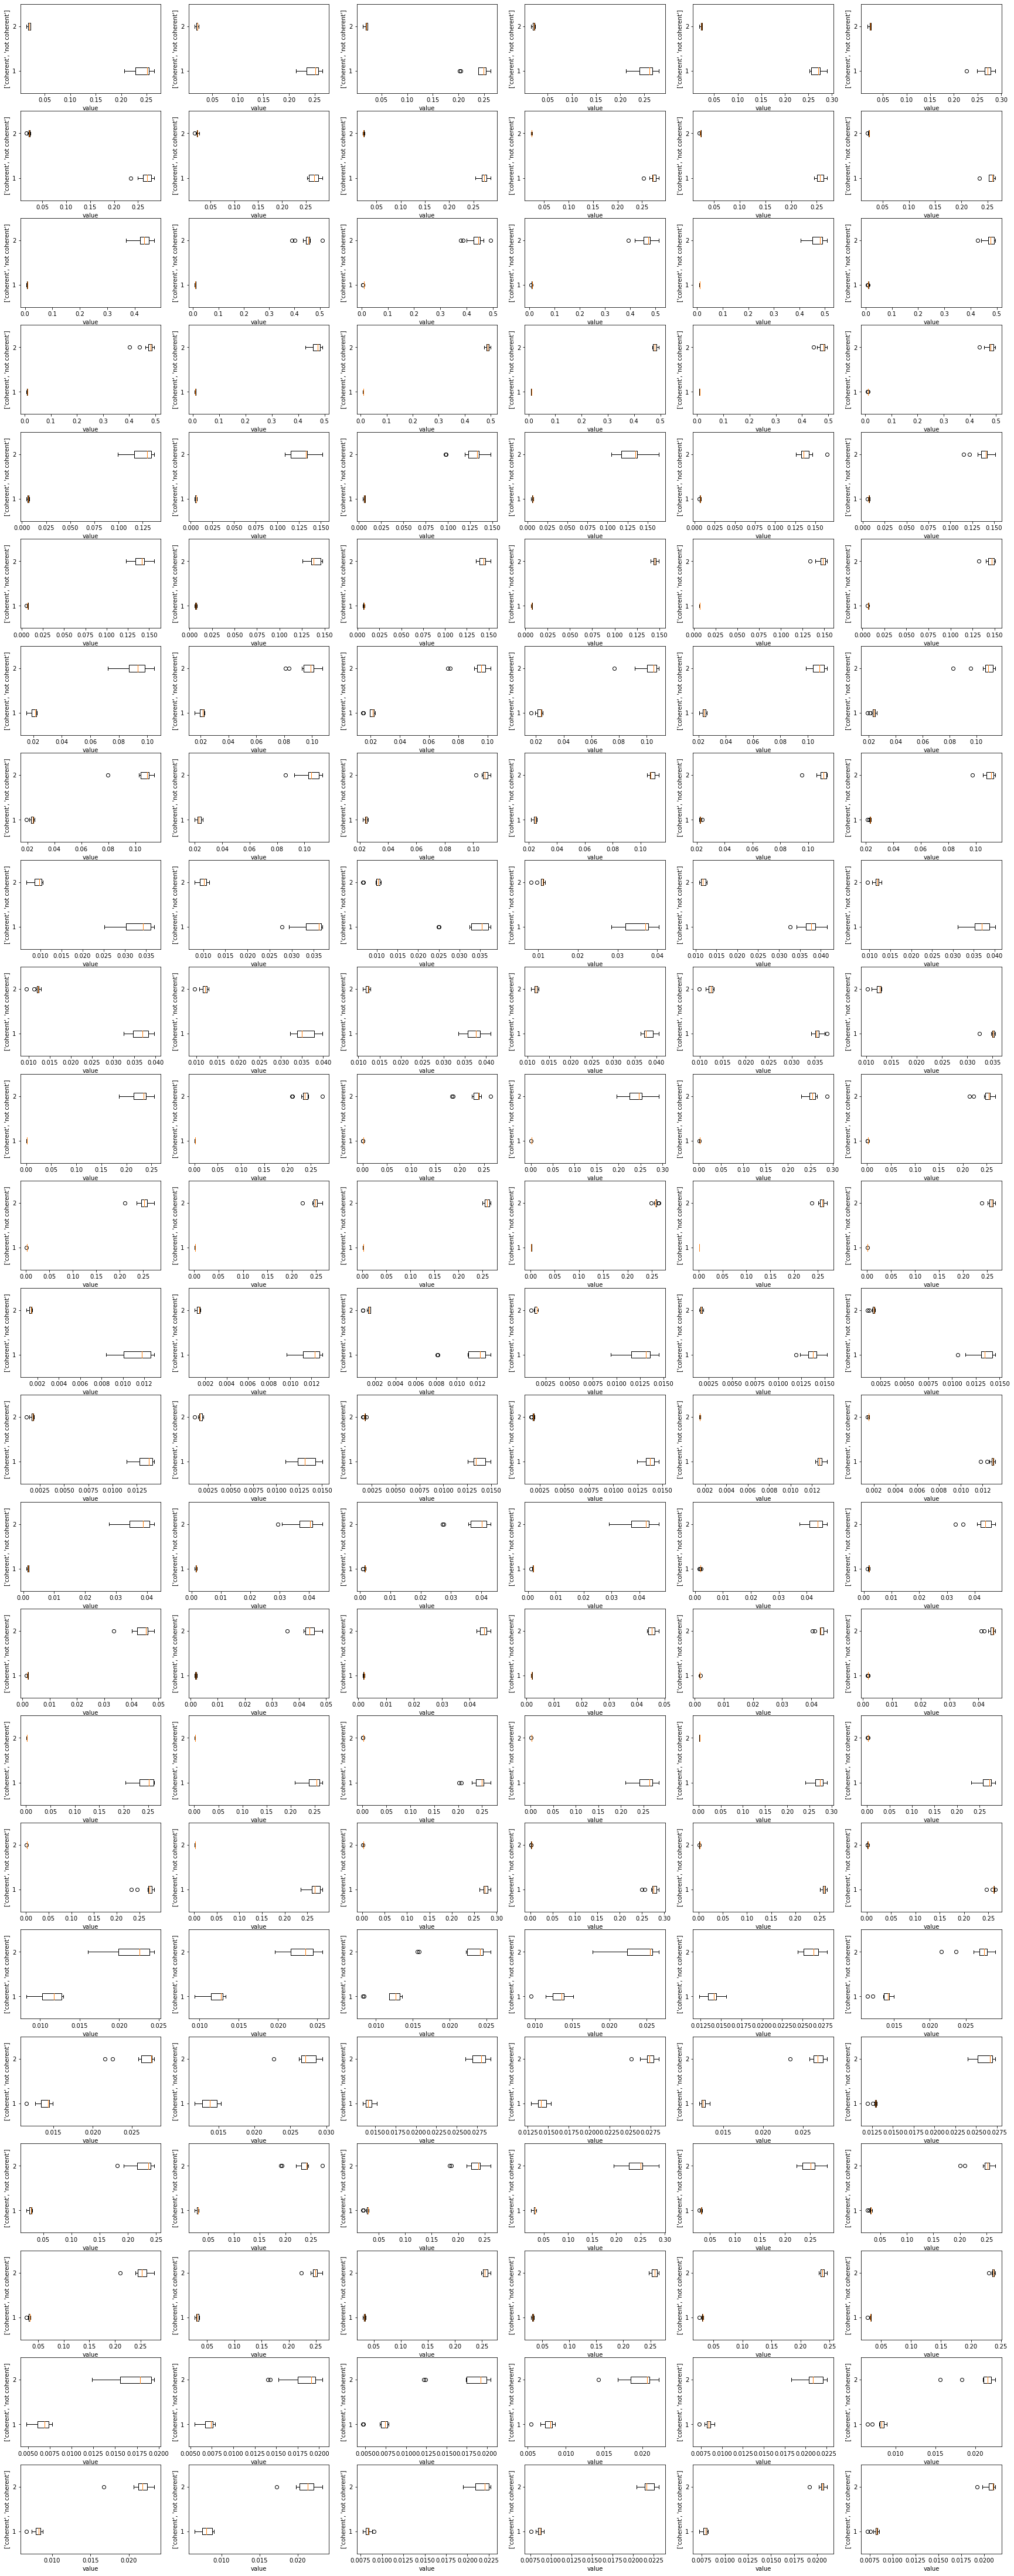

In [33]:
fig, ax = plt.subplots(int(144/6), 6, figsize=(30,80))
I, J = np.unravel_index(np.arange(12*12), shape = (int(144/6), 6))

elem = 0
for l in np.arange(12):
    for h in np.arange(12):
        i, j = I[elem], J[elem]
        #means = attn_distribution_dict['bert'][l][h]
        #variances = [item[1] for item in attn_distribution_dict['bert'][l][h]]

        ax[i][j].boxplot([distrib_attention_dicts['bert'][l][h], distrib_attention_not_coherent_dicts['bert'][l][h]], vert=False, manage_ticks=True)
        ax[i][j].set_xlabel('value')
        ax[i][j].set_ylabel(['coherent', 'not coherent'])

        elem += 1